In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2

from matplotlib import pylab as plt
import psdio

import warnings
warnings.filterwarnings("ignore")

In [2]:
psd_path     = "sample_31.psd"
psd_npy      = psdio.large_psd_to_npy(psd_path)
image, cells = psdio.get_masks_from_layer(psd_npy)

image        = image[:,:,0].astype(float)
image        = image/image.max()

Unknown image resource 1092
Unknown key: b'CAI '
Unknown tagged block: b'CAI ', b'\x00\x00\x00\x03\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00 ... =144'


In [21]:
image.shape, cells.shape ### one layer per cell -> Nr. of cells = Nr. of layers

((1080, 1080), (220, 1080, 1080))

In [22]:
instance  = np.sum((cells.T*np.arange(1,len(cells)+1).T).T,0)
semantics = instance.astype(bool)

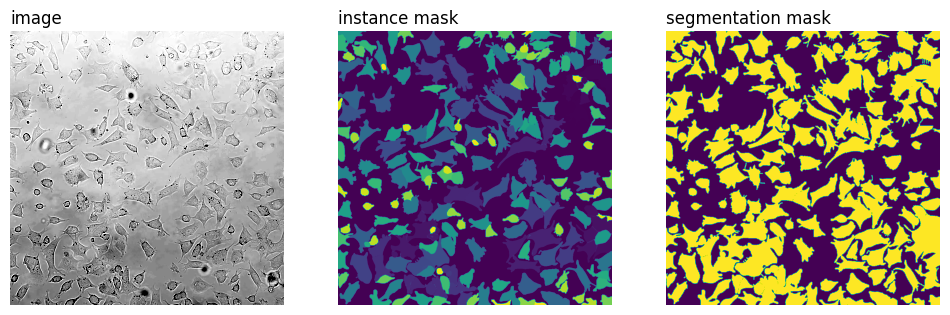

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(image,"Greys_r",vmin=0.4,vmax=0.6)
plt.axis("off")
plt.title("image", loc="left")
plt.subplot(132)
plt.imshow(instance)
plt.axis("off")
plt.title("instance mask", loc="left")
plt.subplot(133)
plt.imshow(semantics)
plt.axis("off")
plt.title("segmentation mask", loc="left")
plt.show()

# Detection 
## Rule/filter based detection
### Background removal

- https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rolling_ball.html
- https://photutils.readthedocs.io/en/stable/background.html

In [3]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

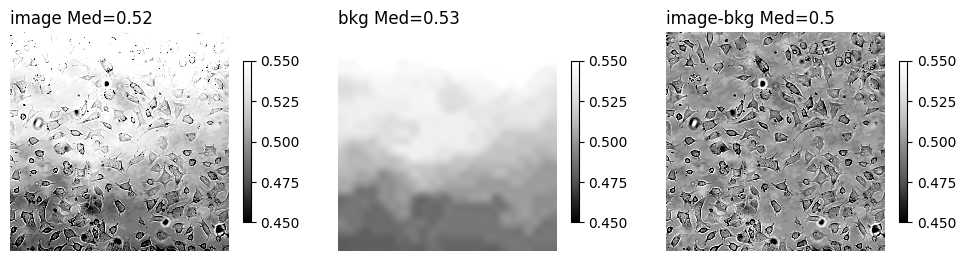

In [163]:
sigma_clip    = SigmaClip(sigma=4.0)
bkg_estimator = MedianBackground()
bkg           = Background2D(image, 
                             (40, 40), 
                             filter_size=(3, 3),
                             sigma_clip=sigma_clip, 
                             bkg_estimator=bkg_estimator).background

bkg_image     = image-bkg+0.5
#bkg_image     = bkg_image/bkg_image.max()


plt.figure(figsize=(12,7))
plt.subplot(131)
plt.imshow(image,"Greys_r",vmin=0.45,vmax=0.55)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("image Med="+str(round(np.median(image),2)), loc="left")
plt.subplot(132)
plt.imshow(bkg,"Greys_r",vmin=0.45,vmax=0.55)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("bkg Med="+str(round(np.median(bkg),2)), loc="left")
plt.subplot(133)
plt.imshow(bkg_image,"Greys_r",vmin=0.45,vmax=0.55)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("image-bkg Med="+str(round(np.median(bkg_image),2)), loc="left")
plt.show()

### Sobel Filter

### Resources
- https://scikit-image.org/docs/stable/auto_examples/applications/plot_human_mitosis.html
- https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_join_segmentations.html
- https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_expand_labels.html
- https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_random_walker_segmentation.html
- https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_morphsnakes.html

In [4]:
from scipy import ndimage
from skimage.filters import sobel
from skimage.segmentation import watershed
from skimage import morphology

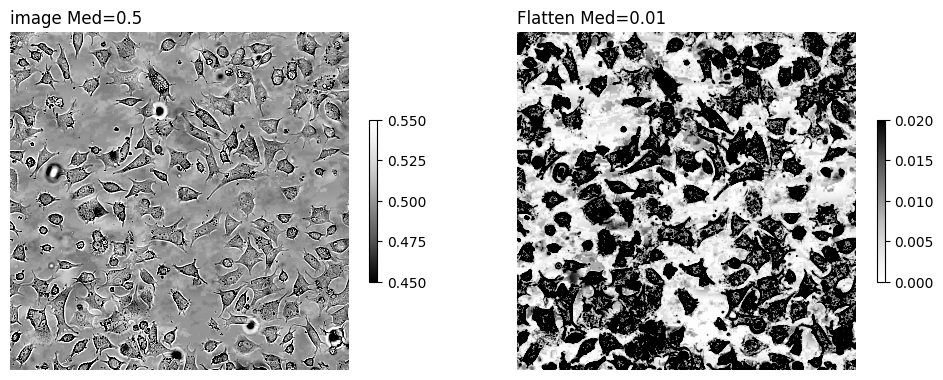

In [213]:
flatten = np.abs(bkg_image-np.median(bkg_image))

plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(bkg_image,"Greys_r",vmin=0.45,vmax=0.55)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("image Med="+str(round(np.median(bkg_image),2)), loc="left")
plt.subplot(122)
plt.imshow(flatten,"Greys",vmin=0,vmax=0.02)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("Flatten Med="+str(round(np.median(flatten),2)), loc="left")
plt.show()

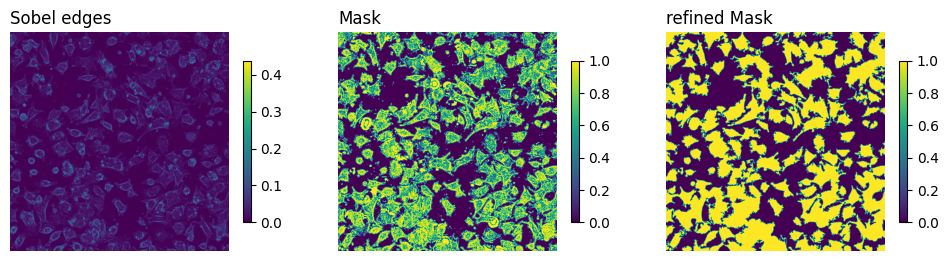

In [214]:
EDGE_SIGMA_B = 3
EDGE_SIGMA_F = 3

edges                  = sobel(bkg_image)
markers                = np.zeros_like(edges,dtype="uint8")

foreground, background = 1, 2

markers[flatten < np.std(edges)/EDGE_SIGMA_B] = background
markers[flatten > np.std(edges)/EDGE_SIGMA_F] = foreground

ws   = 2.-watershed(edges, markers)


mask = morphology.remove_small_holes(ws.astype(bool),
                                     area_threshold=400)

mask = morphology.remove_small_objects(mask,
                                       min_size=400)

plt.figure(figsize=(12,7))
plt.subplot(131)
plt.imshow(edges)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("Sobel edges", loc="left")

plt.subplot(132)
plt.imshow(ws)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("Mask", loc="left")

plt.subplot(133)
plt.imshow(mask)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("refined Mask", loc="left")
plt.show()

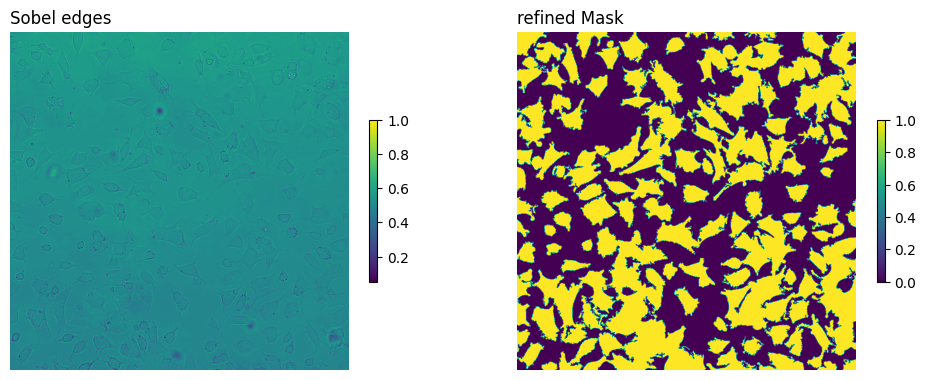

In [6]:
def detect_cells(image,bkg_sigma=4.0, edge_sigma=3, hsize=400, obsize=400):
    #### bgk removal
    sigma_clip    = SigmaClip(sigma=bkg_sigma)
    bkg_estimator = MedianBackground()
    bkg           = Background2D(image, 
                                 (40, 40), 
                                 filter_size=(3, 3),
                                 sigma_clip=sigma_clip, 
                                 bkg_estimator=bkg_estimator).background

    bkg_image     = image-bkg+0.5
    
    ##### sobel filter
    edges         = sobel(bkg_image)
    
    ##### watershed segmentation
    markers       = np.zeros_like(edges,dtype="uint8")
    foreground, background = 1, 2

    markers[edges < np.std(edges)/edge_sigma] = background
    markers[edges > np.std(edges)/edge_sigma] = foreground

    ws   = 2.-watershed(edges, markers)


    mask = morphology.remove_small_holes(ws.astype(bool),
                                         area_threshold=hsize)

    mask = morphology.remove_small_objects(mask,
                                           min_size=obsize)
    
    return mask

mask = detect_cells(image)

plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(image)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("Sobel edges", loc="left")

plt.subplot(122)
plt.imshow(mask)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("refined Mask", loc="left")
plt.show()

Unknown image resource 1092
Unknown key: b'CAI '
Unknown tagged block: b'CAI ', b'\x00\x00\x00\x03\x00\x00\x00\x10\x00\x00\x00\x01\x00\x00\x00\x00 ... =144'


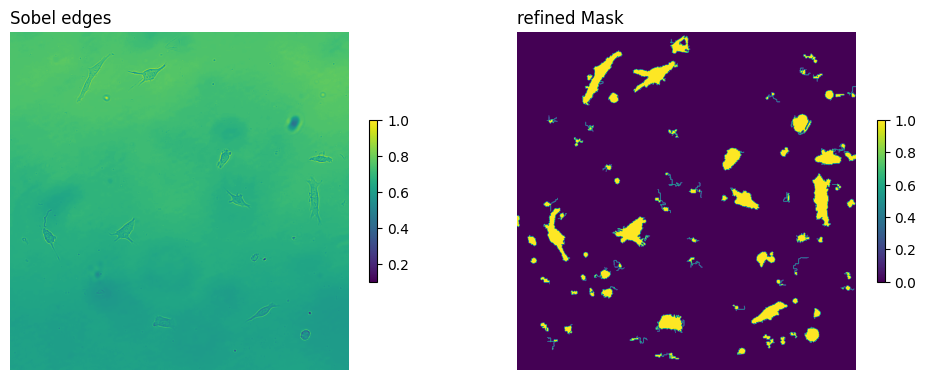

In [11]:
psd_path     = "sample_16.psd"
psd_npy      = psdio.large_psd_to_npy(psd_path)
image, cells = psdio.get_masks_from_layer(psd_npy)

image        = image[:,:,0].astype(float)
image        = image/image.max()

mask         = detect_cells(image,edge_sigma=2)

plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(image)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("Sobel edges", loc="left")

plt.subplot(122)
plt.imshow(mask)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("refined Mask", loc="left")
plt.show()

In [218]:
image.shape

(1608, 1608)

In [167]:
from skimage import filters

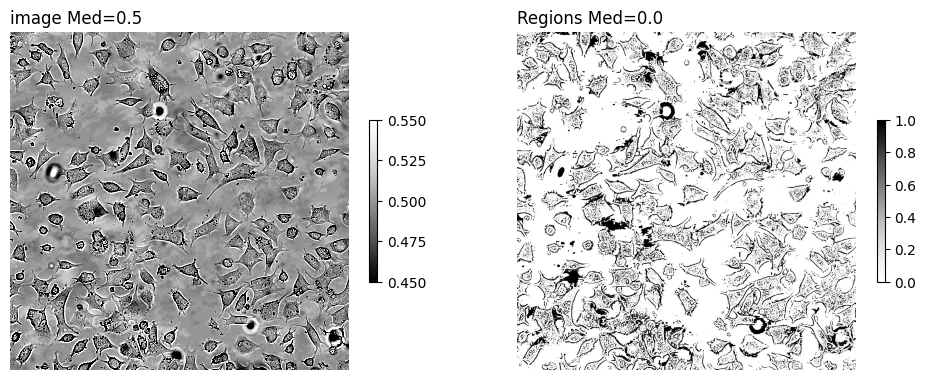

In [173]:
thresholds = filters.threshold_multiotsu(image, classes=2,)
regions    = np.digitize(bkg_image, bins=thresholds)

plt.figure(figsize=(12,7))
plt.subplot(121)
plt.imshow(bkg_image,"Greys_r",vmin=0.45,vmax=0.55)
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("image Med="+str(round(np.median(bkg_image),2)), loc="left")
plt.subplot(122)
plt.imshow(regions,"Greys")
plt.colorbar(shrink=0.3)
plt.axis("off")
plt.title("Regions Med="+str(round(np.median(regions),2)), loc="left")
plt.show()